In [215]:
from glob import glob
import numpy as np
from evFileProcessing import evFuncs # ev COM functions
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

def mwd(df):
    df = df.rename(columns={'datetime':'dt'})
    binCenters = np.arange(2.5,5*df.layer.unique().max(),5)
    depth = []
    #print('appending bin centers...')
    for layer in df.layer:
        depth.append(binCenters[int(layer)-1])
    df['depthBin'] = depth
    df['weightedSA'] = df.sA*df.depthBin
    df = df.groupby(['dt'])[["sA", "weightedSA"]].sum()
    df['mwd'] = df.weightedSA/df.sA
    return df

def readTracks(file):
    dfTracks = pd.read_csv(file)
    dfTracks['Date_S'] = dfTracks['Date_S'].astype(str)
    dfTracks['Datetime'] = pd.to_datetime(dfTracks['Date_S'] + ' ' + dfTracks['Time_S'])
    dfTracks = dfTracks.drop(['Date_S','Time_S'], axis=1)
    dfTracks = dfTracks.set_index('Datetime')
    return dfTracks

def readCTD(file):
    df = pd.read_csv(file)
    df = df[df.Sal > 20]
    df['dt'] = pd.to_datetime(df['Date']+df['Time'])
    df = df.set_index('dt')
    df.Temp.plot()
    return df

def bigFig(df,dfT,col):
    pltDict = {'D1':[0,0,10000],'D2':[0,0,10000],'D3':[1,0,3000]}
    f, [ax1,ax2,ax3,ax4] = plt.subplots(4,1,figsize=(20,11),sharex=True, sharey=True)
    ax1=plt.subplot(411)
    a = df['sA'].resample('2H').sum()
    a.plot( style='.',label='Wakeups',legend=False,fontsize='18',axes=ax1, color=col)
    a.resample('D').mean().plot(legend=False,label='Daily Mean', axes=ax1,linewidth=2,color='k')
    if pltDict[df.name][0]==1:
        ax1.axvspan(pd.to_datetime('2017-8-01'), pd.to_datetime('2018-8-14'), ymin=-60, ymax=3000, alpha=0.3, color='grey')
    ax1.set_ylim([-60,pltDict[df.name][2]])
    #ax1.set_yticks([0,1000,2000,3000])
    ax1.set_xlim([pd.to_datetime('2017-8-01'),pd.to_datetime('2019-9-10')])
    ax1.grid()
    ax1.legend(['Wakeup Mean','Daily Mean'], fontsize=18)
    ax1.set_xticklabels([])
    ax1.xaxis.label.set_visible(False)
    plt.ylabel('70 kHz Backscatter\n(s$_{A}$, m$^{2}$ nmi$^{-2}$)',fontsize=16)

    ax2=plt.subplot(412)
    dfmwd = mwd(df)
    a = dfmwd['mwd']
    a.plot( style='.',label='Wakeups',legend=False,fontsize='18',axes=ax2, color = col)
    a.resample('D').mean().plot(legend=False,label='Daily Mean', axes=ax2,linewidth=2,color='k')
    ax2.set_ylim([0,50])
    ax2.set_xlim([pd.to_datetime('2017-8-01'),pd.to_datetime('2019-9-10')])
    if pltDict[df.name][0]==1:
        ax2.axvspan(pd.to_datetime('2017-8-01'), pd.to_datetime('2018-8-14'), ymin=0, ymax=50, alpha=0.3, color='grey')
    ax2.grid()
    ax2.set_xticklabels([])
    ax2.xaxis.label.set_visible(False)
    ax2.invert_yaxis()
    plt.ylabel('Weighted\nMean Depth (m)\n',fontsize=16)

    ax3=plt.subplot(413)
    dfT['SigBS_mean'] = 10**(dfT.TS_mean/10)
    a = 10*np.log10(dfT.SigBS_mean.resample('H').mean())
    a.plot( style='.',label='Wakeups',legend=False,fontsize='18',axes=ax3,color=col)
    a.resample('D').mean().plot(legend=False,label='Daily Mean', axes=ax3,linewidth=2,color='k')
    if pltDict[df.name][0]==1:
        ax3.axvspan(pd.to_datetime('2017-8-01'), pd.to_datetime('2018-8-14'), ymin=-100, ymax=100, alpha=0.3, color='grey')
    ax3.set_ylim([-70,-35])
    ax3.set_xlim([pd.to_datetime('2017-8-01'),pd.to_datetime('2019-9-10')])
    ax3.grid()
    ax3.set_xlabel('Date', fontsize=18)
    plt.ylabel('70 kHz Target Strength\n(dB re 1 m$^{2}$)',fontsize=16)
    plt.subplots_adjust(hspace=.2)

In [ ]:
filesD1Y1 = glob('../data/2018/EVFiles/DAFT1/exports/Loaded*.csv')
filesD1Y2 = glob('../data/2019/EVFiles/DAFT1/exports/Loaded*.csv')
filesD2Y1 = glob('../data/2018/EVFiles/DAFT2/exports/Loaded*.csv')
filesD2Y2 = glob('../data/2019/EVFiles/DAFT2/exports/Loaded*.csv')
filesD3Y2 = glob('../data/2019/EVFiles/DAFT3/exports/Loaded*.csv')
dfD1 = evFuncs.evExports.readEvExports(filesD1Y1+filesD1Y2)
dfD1.name = 'D1'
dfD2 = evFuncs.evExports.readEvExports(filesD2Y1+filesD2Y2)
dfD2.name = 'D2'
dfD3 = evFuncs.evExports.readEvExports(filesD3Y2)
dfD3.name = 'D3'

df1 = readTracks('../data/analysisFiles/TrackRegions1_linear2.csv')
df4 = readTracks('../data/analysisFiles/TrackRegions4_linear2.csv')
dfD1T = pd.concat([df1,df4])
df2 = readTracks('../data/analysisFiles/TrackRegions2_linear2.csv')
df5 = readTracks('../data/analysisFiles/TrackRegions5_linear2.csv')
dfD2T = pd.concat([df2,df5])
dfD3T = readTracks('../data/analysisFiles/TrackRegions6_linear2.csv')

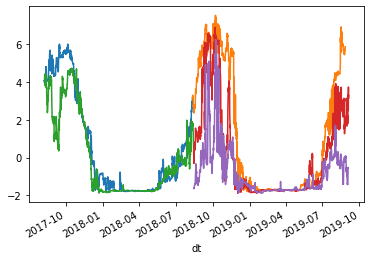

In [216]:
dfCTD1 =readCTD(glob('../data/2018/DAFT1/SBE37/*.csv')[0])
dfCTD4 =readCTD(glob('../data/2019/DAFT1/SBE37/*.csv')[0])
dfCTDD1 = pd.concat([dfCTD1, dfCTD4])
dfCTD2 =readCTD(glob('../data/2018/DAFT2/SBE37/*.csv')[0])
dfCTD5 =readCTD(glob('../data/2019/DAFT2/SBE37/*.csv')[0])
dfCTDD2 = pd.concat([dfCTD2, dfCTD5])
dfCTDD6 =readCTD(glob('../data/2019/DAFT3/SBE37/*.csv')[0])

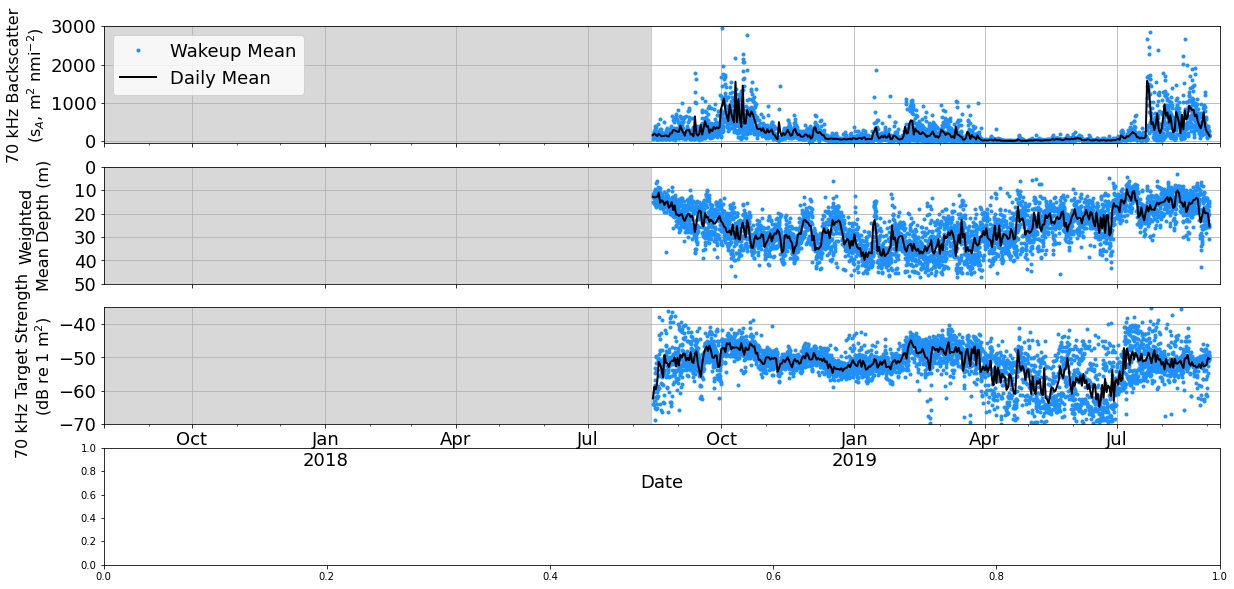

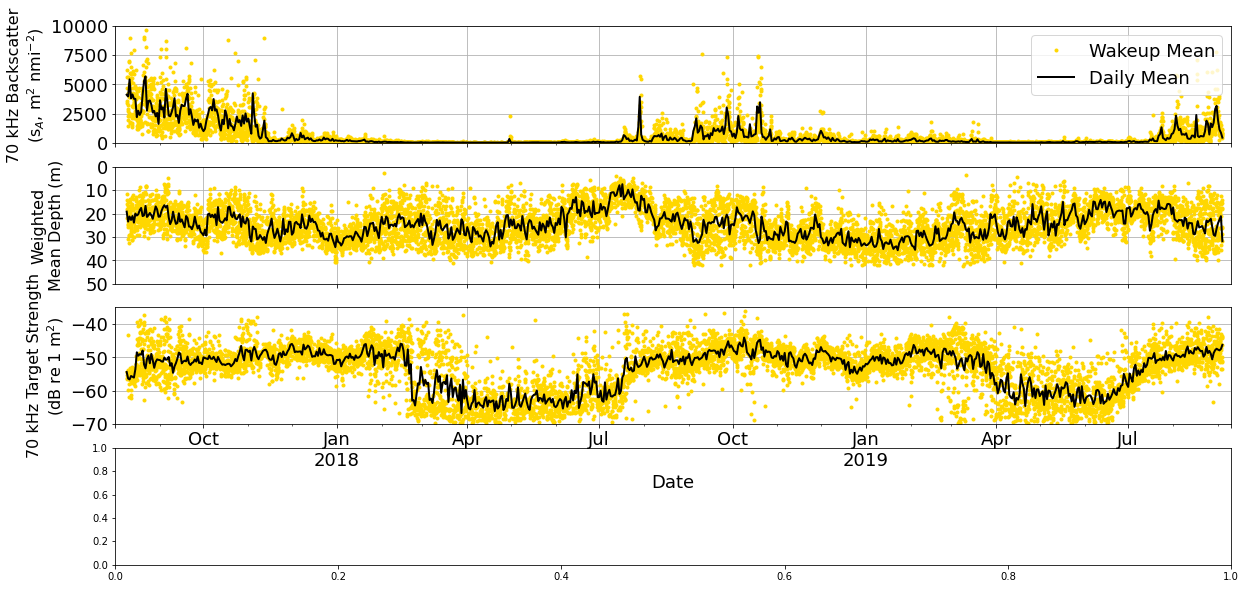

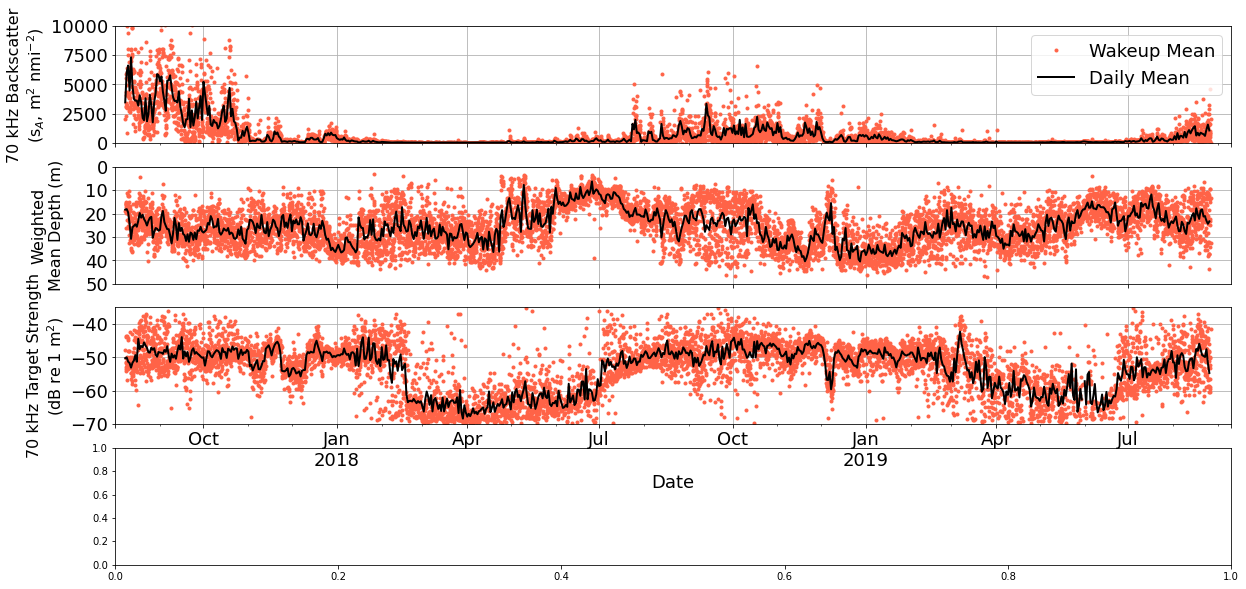

In [160]:
bigFig(dfD3,dfD3T,'dodgerblue')
bigFig(dfD2,dfD2T,'gold')
bigFig(dfD1,dfD1T,'tomato')